In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# CSC380 Decision Tree Classifier Project

<div>
        Members: Sebastian Arana and Austin Baber
</div>

In [2]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

### Imports and globals
<div>We are using scikit-learn, numpy, pandas, matplotlib</div>

In [3]:
import pandas as pd
import math
import os

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

MIN_SUPPORT = 10 # per spec
MAX_TREE_HEIGHT = None # computed dynamically

def set_max_tree_height(num_classes):
    """set MAX_TREE_HEIGHT based on number of classes"""
    global MAX_TREE_HEIGHT
    MAX_TREE_HEIGHT = math.ceil(math.log2(num_classes)) + 1
    print(f"MAX_TREE_HEIGHT set to {MAX_TREE_HEIGHT} for m = {num_classes} classes.")


### Step 1
<div>Parse train/ test data</div>

In [4]:
def load_dataset(path, label = "Class"):
    df = pd.read_csv(path)

    # skip stray index columns
    df = df.loc[:, ~df.columns.str.lower().str.startswith("unnamed")] # bitwise NOT

    y = pd.to_numeric(df[label], errors="raise").astype(int).to_numpy()
    X = df.drop(columns=[label]).astype(float).to_numpy()
    return X, y

### Step 2
<p>Find best split using gini score (logic based on predictive lecture 2 slides)</p>
<ul>
    <li>Define a function to find gini impurity of some labels</li>
    <li>Define a function to find the gini score of a split</li>
    <li>Define a function to get all combinations of classes</li>        
    <li>Fit an SVM with the best split</li>
</ul>

In [5]:
def gini_impurity(y):
    """compute impurity for labels y"""
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts = True)
    p = counts / counts.sum()
    return 1 - np.sum(p**2)

def gini_score(y_left, y_right):
    """weighted impurity of a split"""
    n = len(y_left) + len(y_right)
    if n == 0:
        return np.inf
    return (len(y_left)/n) * gini_impurity(y_left) + (len(y_right)/n) * gini_impurity(y_right)

def combinations(classes):
    """returns all r = 1 and r = 2 combinations, up to m = 9"""
    """copy/pasted from previous hw assignment"""
    m = len(classes)
    combination_list = []
    for i in classes: # r = 1
        combination_list.append((i,))
    for i in range(m): # r = 2
        for j in range(i + 1, m):
            combination_list.append((classes[i], classes[j]))
    return combination_list    

def best_split(X, y, linear = True):
    """
    try all groupings, fit an SVM, and pick the best split by gini score
    returns: best_clf, left_idx, right_idx
    """
    classes = list(np.unique(y))
    combination_list = combinations(classes)

    best_gini = np.inf
    best_clf = None
    best_left_idx, best_right_idx = None, None

    for group in combination_list:
        # binary labels: 1 if in group, else 0
        y_binary = np.where(np.isin(y, group), 1, -1)
        # skip if all same label
        if len(np.unique(y_binary)) < 2:
            continue

        # train SVM
        kernel = 'linear' if linear else 'rbf'
        clf = SVC(kernel = kernel, C=1)
        clf.fit(X, y_binary)

        # split data based on decision function
        decision_vals = clf.decision_function(X)
        left_idx = decision_vals >= 0
        right_idx = ~left_idx # bitwise NOT
        if left_idx.sum() == 0 or right_idx.sum() == 0: # get out
            continue

        # compute gini
        gini = gini_score(y[left_idx], y[right_idx])

        # we want lower gini
        if gini < best_gini:
            best_gini = gini
            best_clf = clf
            best_left_idx = left_idx
            best_right_idx = right_idx

    return best_clf, best_left_idx, best_right_idx


### Step 3
<p>Build Tree: Node object and recursive tree builder function</p>
<p>Tree object has these fields:</p>
<ul>
    <li>is_leaf: Makes leaf checking quick since tree is unchanging</li>
    <li>label: Class for this node. Only leaves have this assigned.</li>
    <li>clf: SVC with the best split</li>        
    <li>left,right: left/right child Nodes</li>
</ul>

In [6]:
class Node:
    def __init__(self):
        self.is_leaf = False
        self.label = None
        self.clf = None
        self.left = None
        self.right = None
        
def build_tree(X, y, depth = 0, max_depth = None, linear = True):
    node = Node()

    if max_depth is None:
        max_depth = MAX_TREE_HEIGHT

    # base case
    if depth >= max_depth or len(np.unique(y)) == 1 or len(y) < MIN_SUPPORT:
        node.is_leaf = True
        node.label = np.bincount(y).argmax()
        return node

    # find best split
    clf, left_idx, right_idx = best_split(X, y, linear=linear)

    # if none, make leaf
    if clf is None:
        node.is_leaf = True
        node.label = int(np.bincount(y).argmax())
        return node
    node.clf = clf
    node.left  = build_tree(X[left_idx],  y[left_idx],  depth+1, max_depth, linear)
    node.right = build_tree(X[right_idx], y[right_idx], depth+1, max_depth, linear)
    return node

### Step 4
<p>Make predictions on a set of feature values</p>
<ul>
    <li>predict1: traverses our decision tree for a set of feature values</li>
    <li>predict: applies predict1 to a list of sets of feature valures</li>
</ul>

In [7]:
def predict1(node, x):
    """traverse tree to predict label for a sample"""
    if node.is_leaf:
        return node.label
    decision_val = node.clf.decision_function([x])[0]
    if decision_val >= 0:
        return predict1(node.left, x)
    else:
        return predict1(node.right, x)

def predict(node, X):
    return np.array([predict1(node, x) for x in X])

### Per-Dataset Classification
<ul>
    <li>train_and_eval: builds a tree for a dataset and predicts classes</li>
    <li>count_leaves: helper to determine leaf count</li>
</ul>

In [8]:
def train_and_eval(train_csv, test_csv, linear = True):
    X_train, y_train = load_dataset(train_csv)
    X_test, y_test = load_dataset(test_csv)

    set_max_tree_height(len(np.unique(y_train))) # update tree height for this dataset
    tree = build_tree(X_train, y_train, depth = 0, max_depth = MAX_TREE_HEIGHT, linear = linear)
    y_pred = predict(tree, X_test)
    acc = accuracy_score(y_test, y_pred)
    return tree, acc, MAX_TREE_HEIGHT, X_test, y_test


In [9]:
def count_leaves(node):
    if node is None:
        return 0
    if node.is_leaf:
        return 1
    return count_leaves(node.left) + count_leaves(node.right)

### Interactive Plot
<p>Now we use the %matplotlib widget to create our interactive plot.</p>
<p>Plots are clickable, and we run our decision tree on the selected feature set.</p>

In [10]:
def interactive_plot(tree, X, y):
    fig, ax = plt.subplots()

    # Compute the boundary values once
    clf = tree.clf
    minX0D = np.min(X[:, 0])
    maxX0D = np.max(X[:, 0])
    minX1D = np.min(X[:, 1])
    maxX1D = np.max(X[:, 1])
    minX1 = (-clf.intercept_ - clf.coef_[0,0] * minX0D) / clf.coef_[0,1]
    maxX1 = (-clf.intercept_ - clf.coef_[0,0] * maxX0D) / clf.coef_[0,1]

    draw_bounds(tree, X, y, ax)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=y)
    text=plt.xlabel("No selection yet")

    def onclick(event):
        if event.inaxes is not None:
            tx = '%f, %f' % (event.xdata, event.ydata)
            
            try:
                label = predict1(tree,[event.xdata,event.ydata])
                tx += f' {label} is selected'
            except Exception as e:
                tx = ("Error during prediction:", e)

            ax.cla()
            draw_bounds(tree, X, y, ax)
            ax.scatter(X[:, 0], X[:, 1], marker='o', c=y)
            ax.plot([minX0D, maxX0D], [minX1, maxX1])
            ax.set_xlim([minX0D, maxX0D])
            ax.set_ylim([minX1D, maxX1D])
            ax.scatter([event.xdata], [event.ydata], c='r')

            text.set_text(tx)
            fig.canvas.draw_idle()
        else:
            print("Clicked outside of an axis.")

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

def draw_bounds(node,X,y,ax):
    if not node or node.is_leaf:
        return

    clf = node.clf
    
    # Plot boundaries
    minX0D = np.min(X[:, 0])
    maxX0D = np.max(X[:, 0])
    minX1D = np.min(X[:, 1])
    maxX1D = np.max(X[:, 1])
    minX1 = (-clf.intercept_-clf.coef_[0,0]*minX0D)/clf.coef_[0,1]
    maxX1 = (-clf.intercept_-clf.coef_[0,0]*maxX0D)/clf.coef_[0,1]

    # Plot lines
    plt.plot([minX0D,maxX0D],[minX1,maxX1])
    ax.set_xlim([minX0D, maxX0D])
    ax.set_ylim([minX1D, maxX1D])

    draw_bounds(node.left,X,y,ax)
    draw_bounds(node.right,X,y,ax)
    return

## Train and Test Models
<p>Now we run our models on each set of training and test data. What will be printed:</p>
<ul>
    <li>Max tree height for this dataset's number of classes</li>
    <li>Accuracy of our model on the test set</li>
    <li>SciKit's classification report</li>        
    <li>Our interactive plot of the data and boundaries</li>
</ul>

### Dataset 1: Linear

MAX_TREE_HEIGHT set to 3 for m = 4 classes.
Dataset 1 Leaves: 4
Dataset 1 accuracy:  1.0
[[15  0  0  0]
 [ 0 17  0  0]
 [ 0  0 20  0]
 [ 0  0  0 25]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        25

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77




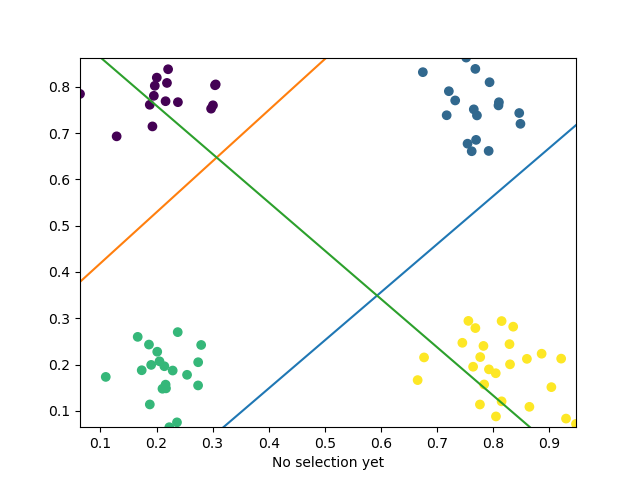

In [11]:
# data 1–3: (linear)
tree1, acc1, depth1, X1_test, y1_test = train_and_eval("data/data1/Data1Train.csv", "data/data1/Data1Test.csv", linear = True)

print("Dataset 1 Leaves:", count_leaves(tree1))
print("Dataset 1 accuracy: ", acc1)
print(confusion_matrix(y1_test, predict(tree1, X1_test)))
print(classification_report(y1_test, predict(tree1, X1_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree1, X1_test, y1_test)

### Dataset 2: Linear

MAX_TREE_HEIGHT set to 3 for m = 4 classes.
Dataset 2 Leaves: 4
Dataset 2 accuracy:  1.0
[[24  0  0  0]
 [ 0 26  0  0]
 [ 0  0 21  0]
 [ 0  0  0 29]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        29

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100




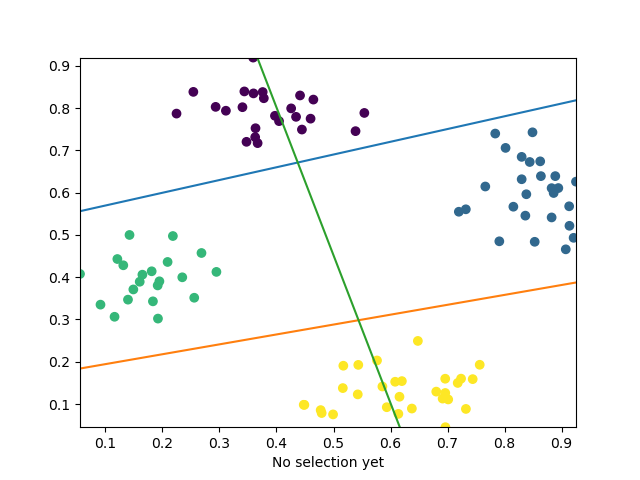

In [12]:
tree2, acc2, depth2, X2_test, y2_test = train_and_eval("data/data2/Data2Train.csv", "data/data2/Data2Test.csv", linear = True)

print("Dataset 2 Leaves:", count_leaves(tree2))
print("Dataset 2 accuracy: ", acc2)
print(confusion_matrix(y2_test, predict(tree2, X2_test)))
print(classification_report(y2_test, predict(tree2, X2_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree2, X2_test, y2_test)

### Dataset 3: Linear

MAX_TREE_HEIGHT set to 3 for m = 3 classes.
Dataset 3 Leaves: 5
Dataset 3 accuracy:  0.95
[[19  1  0]
 [ 0 19  1]
 [ 1  0 19]]
              precision    recall  f1-score   support

           1       0.95      0.95      0.95        20
           2       0.95      0.95      0.95        20
           3       0.95      0.95      0.95        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60




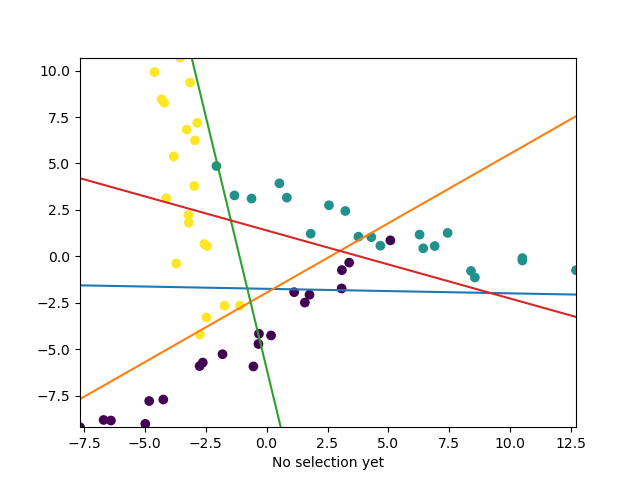

In [13]:
tree3, acc3, depth3, X3_test, y3_test = train_and_eval("data/data3/Data3Train.csv", "data/data3/Data3Test.csv", linear = True)

print("Dataset 3 Leaves:", count_leaves(tree3))
print("Dataset 3 accuracy: ", acc3)
print(confusion_matrix(y3_test, predict(tree3, X3_test)))
print(classification_report(y3_test, predict(tree3, X3_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree3, X3_test, y3_test)

### Dataset 4: Nonlinear

In [14]:
tree4, acc4, depth4, X4_test, y4_test = train_and_eval("data/data4/Data4Train.csv", "data/data4/Data4Test.csv", linear = False)

print("Dataset 4 Leaves:", count_leaves(tree4))
print("Dataset 4 accuracy: ", acc4)
print(confusion_matrix(y4_test, predict(tree4, X4_test)))
print(classification_report(y4_test, predict(tree4, X4_test), zero_division = 0))

MAX_TREE_HEIGHT set to 3 for m = 4 classes.
Dataset 4 Leaves: 4
Dataset 4 accuracy:  1.0
[[15  0  0  0]
 [ 0 33  0  0]
 [ 0  0 24  0]
 [ 0  0  0 24]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

